## APPLIED DATA ANALYSIS - Course Project 

## Free Diving into Food Facts

In this notebook , I am trying to clean and prepare the dataset to answer the 4th question proposed in the readme  
**How do ingredients or categories influence the selected nutrition scores?** 

### Imports needed 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import re
import sqlite3
from datetime import datetime
%matplotlib inline

In [2]:
food_facts_df = pd.read_csv('data/en.openfoodfacts.org.products.csv', encoding='UTF-8', sep='\t',low_memory=False)

In [3]:
print('There are {:,} rows '.format(food_facts_df.shape[0]) + 'and {} columns in our data'.format(food_facts_df.shape[1]))


There are 1,029,403 rows and 175 columns in our data


In [4]:
food_facts_df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,100g,...,NaN,18.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#lets fix the code as indes 
food_facts_df.set_index('code', inplace=True)

As we can see from the 5 first rows in the dataset, the data is messy and has a huge number of NaNs. Let's try first to deal with NaNs. 

Before dealing with NaNs and duplicates, let's try to see what are the different columns of the dataset 

In [7]:
food_facts_df.columns

Index(['url', 'creator', 'created_t', 'created_datetime', 'last_modified_t',
       'last_modified_datetime', 'product_name', 'generic_name', 'quantity',
       'packaging',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=174)

This dataset is provided with a text file describing the different fields as follows : 
- fields that end with _t are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)
- fields that end with _datetime are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
- fields that end with _tags are comma separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)
- fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language
- fields that end with _100g correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product
- fields that end with _serving correspond to the amount of a nutriment (in g, or kJ for energy) for 1 serving of the product


This can help us to remove all the columns that do not correpond to ingeredients or nutrition score. We can see that all the nutrition facts columns end with "_100g"

In [8]:
# We drop all columns that we deem not interesting and we don't intend to use for our investigation.
nutrition_facts_df = food_facts_df.drop(columns=['creator',
                          'brands',
                          'brands_tags',
                          'categories',
                          'main_category',
                          'countries',
                          'countries_tags',
                          'additives',
                          'additives_tags',
                          'categories_tags',
                          'states',
                          'states_en',
                          'states_tags',
                          'url',
                          'quantity',
                          'packaging_tags',
                          'packaging',
                          'created_t',
                          'last_modified_t',
                          'ingredients_from_palm_oil_n', 
                          'ingredients_that_may_be_from_palm_oil_n',
                          'pnns_groups_1',
                          'pnns_groups_2',
                          'image_url',
                          'image_small_url',
                         ])

In [9]:
print('There are {:,} rows '.format(nutrition_facts_df.shape[0]) + 'and {} columns in our data'.format(nutrition_facts_df.shape[1]))


There are 1,029,403 rows and 149 columns in our data


In [10]:
cols_to_keep=[c for c in food_facts_df.columns if c.endswith("_100g")]
cols_to_keep

['energy_100g',
 'energy-from-fat_100g',
 'fat_100g',
 'saturated-fat_100g',
 '-butyric-acid_100g',
 '-caproic-acid_100g',
 '-caprylic-acid_100g',
 '-capric-acid_100g',
 '-lauric-acid_100g',
 '-myristic-acid_100g',
 '-palmitic-acid_100g',
 '-stearic-acid_100g',
 '-arachidic-acid_100g',
 '-behenic-acid_100g',
 '-lignoceric-acid_100g',
 '-cerotic-acid_100g',
 '-montanic-acid_100g',
 '-melissic-acid_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 '-alpha-linolenic-acid_100g',
 '-eicosapentaenoic-acid_100g',
 '-docosahexaenoic-acid_100g',
 'omega-6-fat_100g',
 '-linoleic-acid_100g',
 '-arachidonic-acid_100g',
 '-gamma-linolenic-acid_100g',
 '-dihomo-gamma-linolenic-acid_100g',
 'omega-9-fat_100g',
 '-oleic-acid_100g',
 '-elaidic-acid_100g',
 '-gondoic-acid_100g',
 '-mead-acid_100g',
 '-erucic-acid_100g',
 '-nervonic-acid_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 '-sucrose_100g',
 '-glucose_100g',
 '-fructos

In [11]:
print("We have {} nutrition facts".format(len(cols_to_keep)))

We have 107 nutrition facts


In [12]:
nutrition_facts_df=nutrition_facts_df[cols_to_keep]
nutrition_facts_df.head()

,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
code,,,,,,,,,,,,,,,,,,,,,
0000000000017,1569.0,NaN,7.0,3.08,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000000031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000000100,936.0,NaN,8.2,2.20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00000000001111111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000000123,88.0,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



### Dealing with NaNs

In [13]:
NaNs_distribution_series=nutrition_facts_df.isnull().sum().sort_values()
NaNs_distribution_series

energy_100g             206084
proteins_100g           208948
fat_100g                210824
carbohydrates_100g      210867
sugars_100g             224938
                        ...   
water-hardness_100g    1029403
-erucic-acid_100g      1029403
-nervonic-acid_100g    1029403
-melissic-acid_100g    1029403
-elaidic-acid_100g     1029403
Length: 107, dtype: int64

The previous pandas serie contains the distribution of NaNs between columns. Let's try to remove the columns where the number of NaNs exceeds a certain threshold. 

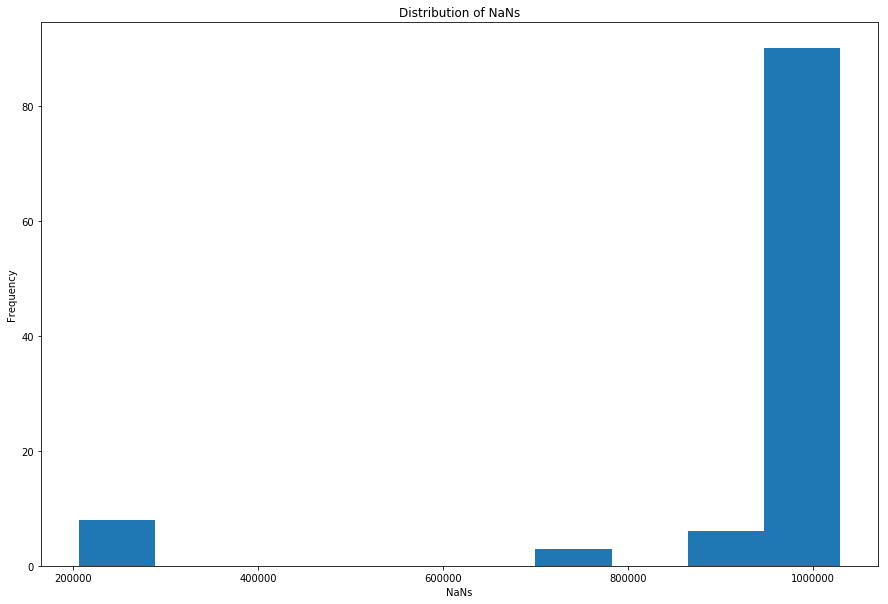

In [14]:
nutrition_facts_df.isnull().sum().plot(kind='hist', figsize=(15,10))
plt.title('Distribution of NaNs')
plt.xlabel('NaNs')

plt.show()

Many columns have huge number of NaNs (More then 85 fields with 1000000 NaNs), let's try to remove them by playing with the threshold value of the dropna function. We will plot afterwords the new distibution of NaNs. Our objective is to remove this huge peak of frequency visulized in the plot above. 

In [61]:
nutrition_facts_thresh_df = nutrition_facts_df.dropna(axis=1, thresh= len(nutrition_facts_df)*0.05, how='all')
nutrition_facts_thresh_df = nutrition_facts_thresh_df.dropna(axis=0, how='all')

print('There are now {:,} rows '.format(nutrition_facts_thresh_df.shape[0]) + 'and {} columns left in our data'.format(nutrition_facts_thresh_df.shape[1]))

There are now 828,050 rows and 17 columns left in our data


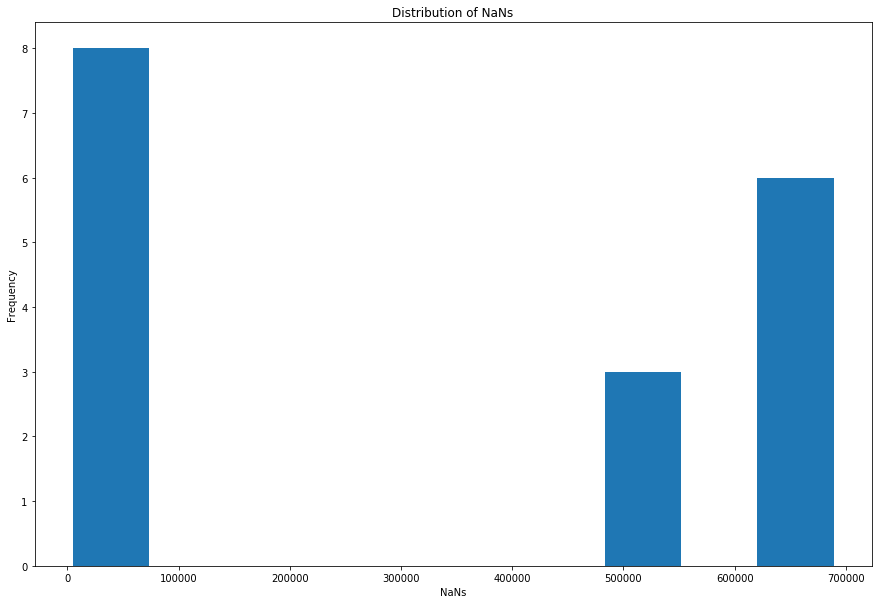

In [62]:
nutrition_facts_thresh_df.isnull().sum().plot(kind='hist', figsize=(15,10))
plt.title('Distribution of NaNs')
plt.xlabel('NaNs')

plt.show()

In [63]:
nutrition_facts_thresh_df.isnull().sum().sort_values()

energy_100g                  4731
proteins_100g                7595
fat_100g                     9471
carbohydrates_100g           9514
sugars_100g                 23585
salt_100g                   27380
sodium_100g                 27430
saturated-fat_100g          39150
fiber_100g                 525599
nutrition-score-fr_100g    536126
nutrition-score-uk_100g    536126
calcium_100g               681939
cholesterol_100g           682914
trans-fat_100g             683705
iron_100g                  685301
vitamin-c_100g             685412
vitamin-a_100g             688974
dtype: int64

In [64]:
nutrition_facts_thresh_df

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,,
0000000000017,1569.0,7.0,3.08,NaN,NaN,70.1,15.0,NaN,7.8,1.40,0.560000,NaN,NaN,NaN,NaN,NaN,NaN
0000000000100,936.0,8.2,2.20,NaN,NaN,29.0,22.0,0.0,5.1,4.60,1.811024,NaN,NaN,NaN,NaN,18.0,18.0
0000000000123,88.0,0.0,0.00,NaN,NaN,4.8,0.4,NaN,0.2,2.04,0.816000,NaN,NaN,NaN,NaN,NaN,NaN
0000000000178,251.0,3.0,1.00,NaN,NaN,10.0,3.0,NaN,2.0,1.15,0.460000,NaN,NaN,NaN,NaN,NaN,NaN
0000000000949,134.0,0.3,0.10,NaN,NaN,5.3,3.9,NaN,0.9,0.42,0.168000,NaN,NaN,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999991042742,1448.0,27.0,17.00,NaN,NaN,19.0,18.0,NaN,6.0,0.19,0.076000,NaN,NaN,NaN,NaN,17.0,17.0
9999991149090,1469.0,0.5,0.00,NaN,NaN,80.0,0.0,NaN,7.0,0.00,0.000000,NaN,NaN,NaN,NaN,0.0,0.0
99999988,1556.0,11.0,1.30,NaN,NaN,58.0,54.0,NaN,6.3,0.02,0.008000,NaN,NaN,NaN,NaN,NaN,NaN


### Removing duplicates

In [65]:
nutrition_facts_thresh_df.drop_duplicates(inplace=True)
nutrition_facts_thresh_df.shape

(640085, 17)

In [66]:
print ("We have now {} of samples with {} fields".format(nutrition_facts_thresh_df.shape[0],
                                                         nutrition_facts_thresh_df.shape[1]))

We have now 640085 of samples with 17 fields


This is the maximum that we can do to decrease the number of NaNs in this dataset. All the fields have a balanced number of NaNs that will not be considered in the analysis. Analysing the impact of the ingredients  with nearly the same number of NaNs on the nutrition score will not be biased. 

We decreased the number of fields to have a reasonable and balanced number of NaNs between them. We need now to remove the outliers from the rows of this dataset. 

Let's check the statistics of our data. 

### Some statistics

In [67]:
nutrition_facts_thresh_df.describe()

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,6.384410e+05,6.340030e+05,6.185700e+05,102040.000000,103464.000000,634097.000000,6.266730e+05,2.472260e+05,6.360520e+05,6.203390e+05,6.202900e+05,100520.000000,103131.000000,106779.000000,103723.000000,236645.000000,236645.000000
mean,1.044037e+37,2.770669e+01,1.245794e+01,0.088566,0.032226,31.131256,2.170822e+01,2.136528e+02,1.480393e+02,1.334206e+02,5.361682e+01,0.003196,0.026990,0.250380,0.008757,9.267413,8.898895
std,8.342115e+39,1.099018e+04,5.707440e+03,1.743832,1.067735,1082.554556,5.779279e+03,1.023917e+05,1.113547e+05,1.027009e+05,4.108247e+04,0.431342,0.851168,7.672196,0.394395,8.807860,9.198998
min,0.000000e+00,0.000000e+00,0.000000e+00,-3.570000,0.000000,0.000000,-1.786000e+01,-2.000000e+01,-8.000000e+02,0.000000e+00,0.000000e+00,-0.000340,-0.002100,0.000000,-0.000260,-15.000000,-15.000000
25%,4.560000e+02,1.000000e+00,1.330000e-01,0.000000,0.000000,4.900000,1.000000e+00,0.000000e+00,1.600000e+00,9.000000e-02,3.200000e-02,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,1.092000e+03,7.140000e+00,1.900000e+00,0.000000,0.000000,18.000000,4.590000e+00,1.600000e+00,5.800000e+00,5.500000e-01,2.120000e-01,0.000000,0.000000,0.042000,0.001120,10.000000,8.000000
75%,1.674000e+03,2.100000e+01,7.100000e+00,0.000000,0.023000,54.000000,2.110000e+01,3.600000e+00,1.100000e+01,1.300000e+00,5.200000e-01,0.000107,0.004200,0.114000,0.002450,16.000000,16.000000
max,6.665559e+42,8.748748e+06,4.488758e+06,369.000000,141.000000,857855.000000,4.574988e+06,5.089889e+07,8.880858e+07,8.088869e+07,3.235548e+07,100.000000,100.000000,950.000000,50.000000,40.000000,40.000000


Well, It seems that there is no difference between the `nutrition-score-fr_100g` and `nutrition-score-uk_100g`. Let's analyse that. 

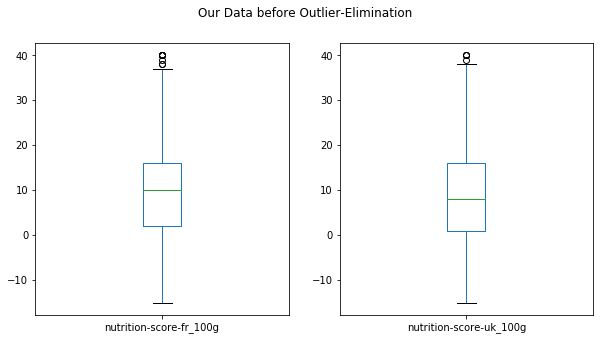

In [68]:
nutrition_facts_thresh_df[['nutrition-score-fr_100g','nutrition-score-uk_100g']].select_dtypes(include=float).plot(kind='box', subplots=True, title='Our Data before Outlier-Elimination', figsize=(10,5))

plt.show()

As expected, the two scores has the same distribution except some outliers in the `nutrition-score-fr_100g`. let's remove all the rows where the two columns doesn't have the same nutrition score. 

In [69]:
nutrition_facts_thresh_df.head()

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,,
0000000000017,1569.0,7.0,3.08,NaN,NaN,70.1,15.0,NaN,7.8,1.40,0.560000,NaN,NaN,NaN,NaN,NaN,NaN
0000000000100,936.0,8.2,2.20,NaN,NaN,29.0,22.0,0.0,5.1,4.60,1.811024,NaN,NaN,NaN,NaN,18.0,18.0
0000000000123,88.0,0.0,0.00,NaN,NaN,4.8,0.4,NaN,0.2,2.04,0.816000,NaN,NaN,NaN,NaN,NaN,NaN
0000000000178,251.0,3.0,1.00,NaN,NaN,10.0,3.0,NaN,2.0,1.15,0.460000,NaN,NaN,NaN,NaN,NaN,NaN
0000000000949,134.0,0.3,0.10,NaN,NaN,5.3,3.9,NaN,0.9,0.42,0.168000,NaN,NaN,NaN,NaN,1.0,1.0


### What about outliers in the row data?

Let's try to remove all the datapoints that are above or below 3 times the standard deviation assuming that our random varialbes are Gaussians

In [70]:
nutrition_facts_thresh_df = nutrition_facts_thresh_df[np.abs(nutrition_facts_thresh_df['energy_100g']-nutrition_facts_thresh_df
                                                             ['energy_100g'].mean())<=(3*nutrition_facts_thresh_df['energy_100g'].std())]
nutrition_facts_thresh_df = nutrition_facts_thresh_df[np.abs(nutrition_facts_thresh_df['fat_100g']-nutrition_facts_thresh_df
                                                             ['fat_100g'].mean())<=(3*nutrition_facts_thresh_df['fat_100g'].std())]
nutrition_facts_thresh_df = nutrition_facts_thresh_df[np.abs(nutrition_facts_thresh_df['saturated-fat_100g']-nutrition_facts_thresh_df
                                                             ['saturated-fat_100g'].mean())<=(3*nutrition_facts_thresh_df['saturated-fat_100g'].std())]
nutrition_facts_thresh_df = nutrition_facts_thresh_df[np.abs(nutrition_facts_thresh_df['trans-fat_100g']-nutrition_facts_thresh_df
                                                             ['trans-fat_100g'].mean())<=(3*nutrition_facts_thresh_df['trans-fat_100g'].std())]
nutrition_facts_thresh_df = nutrition_facts_thresh_df[np.abs(nutrition_facts_thresh_df['cholesterol_100g']-nutrition_facts_thresh_df
                                                             ['cholesterol_100g'].mean())<=(3*nutrition_facts_thresh_df['cholesterol_100g'].std())]
nutrition_facts_thresh_df = nutrition_facts_thresh_df[np.abs(nutrition_facts_thresh_df['carbohydrates_100g']-nutrition_facts_thresh_df
                                                             ['carbohydrates_100g'].mean())<=(3*nutrition_facts_thresh_df['carbohydrates_100g'].std())]
nutrition_facts_thresh_df = nutrition_facts_thresh_df[np.abs(nutrition_facts_thresh_df['sugars_100g']-nutrition_facts_thresh_df
                                                             ['sugars_100g'].mean())<=(3*nutrition_facts_thresh_df['sugars_100g'].std())]
nutrition_facts_thresh_df = nutrition_facts_thresh_df[np.abs(nutrition_facts_thresh_df['fiber_100g']-nutrition_facts_thresh_df
                                                             ['fiber_100g'].mean())<=(3*nutrition_facts_thresh_df['fiber_100g'].std())]
nutrition_facts_thresh_df = nutrition_facts_thresh_df[np.abs(nutrition_facts_thresh_df['proteins_100g']-nutrition_facts_thresh_df
                                                             ['proteins_100g'].mean())<=(3*nutrition_facts_thresh_df['proteins_100g'].std())]
nutrition_facts_thresh_df = nutrition_facts_thresh_df[np.abs(nutrition_facts_thresh_df['salt_100g']-nutrition_facts_thresh_df
                                                             ['salt_100g'].mean())<=(3*nutrition_facts_thresh_df['salt_100g'].std())]
nutrition_facts_thresh_df = nutrition_facts_thresh_df[np.abs(nutrition_facts_thresh_df['sodium_100g']-nutrition_facts_thresh_df
                                                             ['sodium_100g'].mean())<=(3*nutrition_facts_thresh_df['sodium_100g'].std())]
nutrition_facts_thresh_df = nutrition_facts_thresh_df[np.abs(nutrition_facts_thresh_df['vitamin-a_100g']-nutrition_facts_thresh_df
                                                             ['vitamin-a_100g'].mean())<=(3*nutrition_facts_thresh_df['vitamin-a_100g'].std())]
nutrition_facts_thresh_df = nutrition_facts_thresh_df[np.abs(nutrition_facts_thresh_df['vitamin-c_100g']-nutrition_facts_thresh_df
                                                             ['vitamin-c_100g'].mean())<=(3*nutrition_facts_thresh_df['vitamin-c_100g'].std())]
nutrition_facts_thresh_df = nutrition_facts_thresh_df[np.abs(nutrition_facts_thresh_df['calcium_100g']-nutrition_facts_thresh_df
                                                             ['calcium_100g'].mean())<=(3*nutrition_facts_thresh_df['calcium_100g'].std())]
nutrition_facts_thresh_df = nutrition_facts_thresh_df[np.abs(nutrition_facts_thresh_df['iron_100g']-nutrition_facts_thresh_df
                                                             ['iron_100g'].mean())<=(3*nutrition_facts_thresh_df['iron_100g'].std())]
nutrition_facts_thresh_df = nutrition_facts_thresh_df[np.abs(nutrition_facts_thresh_df['nutrition-score-fr_100g']-nutrition_facts_thresh_df
                                                             ['nutrition-score-fr_100g'].mean())<=(3*nutrition_facts_thresh_df['nutrition-score-fr_100g'].std())]
nutrition_facts_thresh_df = nutrition_facts_thresh_df[np.abs(nutrition_facts_thresh_df['nutrition-score-uk_100g']-nutrition_facts_thresh_df
                                                             ['nutrition-score-uk_100g'].mean())<=(3*nutrition_facts_thresh_df['nutrition-score-uk_100g'].std())]

In [71]:
print("We have only {} rows left".format(nutrition_facts_thresh_df.shape[0]))

We have only 13697 rows left


In [72]:
nutrition_facts_thresh_df.head(20)

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,,
0000000043595,1255.0,0.00,0.000,0.000,0.00000,83.33,66.670,10.000,0.00,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000,3.0,3.0
0000001938067,1090.0,10.70,2.000,0.667,0.00533,38.70,24.700,2.000,3.33,0.64700,0.000259,0.000000,0.001600,0.0133,0.000480,5.0,5.0
0000004302544,1160.0,1.11,0.333,0.000,0.00000,53.30,1.110,2.220,10.00,1.52000,0.000610,0.000000,0.000000,0.0222,0.006000,-4.0,-4.0
0000008237798,478.0,6.79,2.860,0.000,0.01070,7.86,0.714,0.357,5.36,0.49900,0.000200,0.000011,0.000429,0.0286,0.000643,0.0,0.0
0000012167005,536.0,6.00,1.000,0.000,0.00000,50.00,19.000,1.000,7.00,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.0
0000020043131,1527.0,1.18,0.000,0.000,0.00000,71.76,4.710,2.400,12.94,1.19634,0.478536,0.000000,0.000000,0.0710,0.004240,3.0,3.0
0000020045791,1749.0,21.76,5.290,0.000,0.07100,51.76,32.940,2.400,5.88,0.67310,0.269240,0.000035,0.000000,0.0880,0.001590,17.0,17.0
0000020047825,1623.0,22.35,11.760,0.000,0.00000,42.35,15.290,2.400,4.71,0.80772,0.323088,0.000070,0.028200,0.0000,0.001690,18.0,18.0
00005487,2243.0,32.14,3.570,0.000,0.00000,57.14,0.000,3.600,7.14,0.95250,0.381000,0.000000,0.021400,0.0000,0.001290,10.0,10.0


In [73]:
nutrition_facts_thresh_stand_df = nutrition_facts_thresh_df.select_dtypes(include=float).transform(lambda x: (x - x.mean()) / x.std())


In [74]:
nutrition_facts_thresh_stand_df.describe()

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,1.369700e+04,1.369700e+04,1.369700e+04,1.369700e+04,1.369700e+04,1.369700e+04,1.369700e+04,1.369700e+04,1.369700e+04,1.369700e+04,1.369700e+04,1.369700e+04,1.369700e+04,1.369700e+04,1.369700e+04,1.369700e+04,1.369700e+04
mean,2.145307e-16,5.259638e-16,-3.752089e-16,-7.841695e-16,3.318349e-15,-6.403143e-15,-1.215251e-14,1.461867e-14,5.843387e-15,-6.344014e-16,8.025230e-15,6.098384e-16,2.417274e-15,-1.441379e-14,1.614415e-15,-5.344828e-16,4.159628e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.436742e+00,-8.004479e-01,-6.661770e-01,-4.166754e+00,-4.227072e-01,-1.199689e+00,-7.667645e-01,-8.166950e-01,-1.074607e+00,-7.436066e-01,-7.395189e-01,-1.204431e-01,-2.675859e-01,-6.124261e-01,-6.134238e-01,-2.410414e+00,-2.348765e+00
25%,-9.336700e-01,-7.501127e-01,-6.661770e-01,-9.735387e-02,-4.227072e-01,-8.513162e-01,-6.912579e-01,-8.166950e-01,-7.153018e-01,-6.374077e-01,-6.416434e-01,-1.204431e-01,-2.675859e-01,-6.124261e-01,-6.134238e-01,-8.534385e-01,-8.212481e-01
50%,-1.282333e-01,-4.001916e-01,-4.072216e-01,-9.735387e-02,-4.227072e-01,-3.416306e-01,-4.468212e-01,-3.255628e-01,-2.539538e-01,-2.040133e-01,-2.052818e-01,-1.204431e-01,-2.675859e-01,-2.950262e-01,-2.205263e-01,-7.495092e-02,-1.665980e-01
75%,7.449749e-01,4.809787e-01,3.262266e-01,-9.735387e-02,4.077713e-02,8.116991e-01,3.626352e-01,3.497439e-01,3.942330e-01,2.582698e-01,2.555486e-01,-1.003406e-02,-1.510031e-01,2.004272e-01,2.799010e-01,8.147492e-01,8.153773e-01
max,7.295339e+00,1.939430e+01,1.262273e+01,2.094144e+01,5.416545e+01,3.466731e+00,3.819302e+00,4.094627e+00,3.324727e+00,1.755839e+01,1.130225e+01,1.088731e+02,2.402050e+01,1.239323e+01,1.833664e+01,2.927787e+00,2.888436e+00


In [75]:
nutrition_facts_thresh_stand_df.head()

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,,
0000000043595,0.198894,-0.800448,-0.666177,-0.097354,-0.422707,2.152490,3.499359,2.252881,-1.074607,-0.743607,-0.739519,-0.120443,-0.267586,-0.612426,-0.613424,-0.519801,-0.493923
0000001938067,-0.016150,-0.151548,-0.356051,2.616936,-0.285464,0.357125,0.813755,-0.202780,-0.596012,-0.233202,-0.738999,-0.120443,-0.163957,-0.509465,-0.414907,-0.297376,-0.275706
0000004302544,0.075081,-0.733132,-0.614541,-0.097354,-0.422707,0.944451,-0.695737,-0.135249,0.362614,0.455490,-0.738295,-0.120443,-0.267586,-0.440566,1.868034,-1.298289,-1.257682
0000008237798,-0.813767,-0.388669,-0.222697,-0.097354,-0.147192,-0.883498,-0.721077,-0.707111,-0.304257,-0.349956,-0.739117,-0.106674,-0.239800,-0.391020,-0.347494,-0.853439,-0.821248
0000012167005,-0.738176,-0.436579,-0.511114,-0.097354,-0.422707,0.811699,0.449020,-0.509737,-0.068552,-0.743607,-0.739519,-0.120443,-0.267586,-0.612426,-0.613424,-0.853439,-0.821248


In [76]:
nutrition_facts_thresh_stand_df["nutrition-score-fr_100g"]
X=nutrition_facts_thresh_stand_df.drop(columns=["nutrition-score-fr_100g","nutrition-score-uk_100g"])

In [77]:
nutrition_facts_thresh_stand_df = nutrition_facts_thresh_stand_df.rename(columns={'nutrition-score-fr_100g': 'nutrition_score_fr_100g',
                            'nutrition-score-uk_100g': 'nutrition_score_uk_100g',
                            'vitamin-c_100g': 'vitamin_c_100g',
                            'vitamin-a_100g': 'vitamin_a_100g',
                            'saturated-fat_100g': 'saturated_fat_100g',
                            'trans-fat_100g': 'trans_fat_100g'})

In [78]:
nutrition_score_regression = sm.ols(formula= """nutrition_score_fr_100g ~ energy_100g
                                   + fat_100g
                                   + fiber_100g
                                   + saturated_fat_100g
                                   + trans_fat_100g
                                   + cholesterol_100g
                                   + carbohydrates_100g
                                   + sugars_100g
                                   + proteins_100g
                                   + salt_100g
                                   + vitamin_a_100g
                                   + vitamin_c_100g
                                   + calcium_100g
                                   + iron_100g""", data = nutrition_facts_thresh_stand_df)
res = nutrition_score_regression.fit()
print(res.summary())

                               OLS Regression Results                              
Dep. Variable:     nutrition_score_fr_100g   R-squared:                       0.775
Model:                                 OLS   Adj. R-squared:                  0.774
Method:                      Least Squares   F-statistic:                     3358.
Date:                     Tue, 05 Nov 2019   Prob (F-statistic):               0.00
Time:                             00:13:33   Log-Likelihood:                -9232.1
No. Observations:                    13697   AIC:                         1.849e+04
Df Residuals:                        13682   BIC:                         1.861e+04
Df Model:                               14                                         
Covariance Type:                 nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

Analysing the regression results from the coeficents of each ingredient, we can deduce the impact of these ingredients on the the nutrition score.  

#### Positive coef 
* `energy_100g` has the highest positive nutrition score ~ 0.4  
* `sugars_100` has the second highest nutrition score ~ 0.37 
* `salt_100g` has the third highest nutrition score ~ 0.30
* `saturated_fat_100g `has the fourth highest nutrition socre ~ 0,27 
#### Negative coef 
* `fiber_100g` has the highest negative nutrition score ~-0.28
From the french nutrition socre datasheet page 24 we see that the highest the nutrition socre is the lowest the nutritional quality is. We can then deduce that all products with high percentage of energy, sugar salt and saturated fat all unhealthy and products with high percentage of fiber are healthy. All other ingredients doesn't have any impact on the nutrition score.  
Analysing the p-value we can deduce that our variables are statiscally significant excep the `vitamin_a_100g`